In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('algo_syn', None)
from algo_syn import *

sys.modules.pop('plots', None)
from plots import *


In [11]:
def simulate(seed, num_periods, true_means, variance, B_arr, B_arr_tr, fixed_windows, train_window, num_trials, alpha, delta, gamma, next_period):

    np.random.seed(seed)

    #B_arr is for val set
    B_arr_ends = np.cumsum(B_arr) - 1
    B_arr_tr_ends = np.cumsum(B_arr_tr) - 1

    cdf_dict = create_empty_dict(fixed_windows, num_trials)
    interval_dict = create_empty_dict(fixed_windows, num_trials)

    seeds = np.arange(num_trials) + 2024

    for (trial, seed) in tqdm(enumerate(seeds)):
        
        np.random.seed(seed)

        X_val = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)
        X_tr = generate_gaussian_sequence(B_arr = B_arr_tr, true_means = true_means, variance=variance)

        for t in range(num_periods-1):
            
            idx_tr = B_arr_tr_ends[t]+1
            idx_val = B_arr_ends[t]+1

            mu_hat = train_synthetic(X_tr[:idx_tr], B_arr_tr[:t+1], train_window)[0]

            if next_period == True:
                mu_t = true_means[t+1]
            else: 
                mu_t = true_means[t]
            #calculate conformity score
            S_t = np.abs(X_val[:idx_val] - mu_hat)
            
            B_arr_t = B_arr[:t+1]

            khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)
            coverage_ARW = calculate_coverage(mu_hat, qt_khat, mu_t, variance)
            #cdf_dict['ARW'][trial].append(np.mean(np.abs(coverage_ARW - 1+alpha)))
            cdf_dict['ARW'][trial].append(coverage_ARW)
            interval_dict['ARW'][trial].append(2*qt_khat)
            
            #baseline: take quantile of fixed k
            for ik, k in enumerate(fixed_windows):
                log2k = int(np.log2(k))
                qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                coverage_k = calculate_coverage(mu_hat, qtk, mu_t, variance)
                cdf_dict[f'Val_{k}'][trial].append(coverage_k)
                interval_dict[f'Val_{k}'][trial].append(2*qtk)

    return cdf_dict, interval_dict

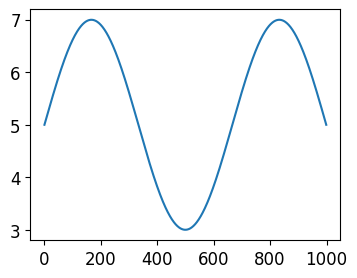

5it [00:06,  1.29s/it]


In [12]:
num_periods = 1000
seed = 6
np.random.seed(seed)
B_arr = np.random.randint(low=2, high=5, size=num_periods)
fixed_windows = [1, 4, 16, 64, 256, 1024]
train_window = [100]
num_trials = 5
variance = 1
alpha, delta, gamma = 0.1, 0.1, 1

#NOTE: change shift patterns
true_means = 2 * np.sin(np.linspace(0, 3 * np.pi, 1000)) + 5
#true_means = 5 * generate_true_means(num_periods-1, 2)
#true_means = 5 * np.ones(num_periods)

plt.figure(figsize=(4,3))
plt.plot(true_means)
plt.show()

#NOTE: change this to (not) predict for the next period instead
next_period = False

parameters = {
    "seed": seed,
    "num_periods": num_periods,
    "true_means": true_means,
    "B_arr": B_arr,
    "B_arr_tr": 3 * B_arr,  # This will be calculated based on B_arr
    "fixed_windows": fixed_windows,
    "train_window": train_window,
    "num_trials": num_trials,
    "variance": variance, 
    "next_period": next_period,
    "alpha": alpha, "delta": delta, "gamma": gamma,
}

cdf_dict, interval_dict = simulate(**parameters)

predicting for next period: False
mae [0.02684212 0.18888561 0.07875324 0.03910846 0.04458987 0.0609313
 0.07554117]
se_ae [0.00049313 0.00108409 0.00148986 0.00067081 0.00262993 0.00092854
 0.00031389]
mse [0.00120316 0.06955841 0.01178673 0.00258838 0.00311204 0.00468571
 0.00661272]
se_mse [2.39934594e-05 8.80403154e-04 3.86435128e-04 9.29389301e-05
 3.03938390e-04 8.54224806e-05 4.46578648e-05]
mean_interval [3.91205604 3.06317673 3.59822681 3.71089392 3.47728402 4.90740001
 6.20508453]
se_interval [0.03979587 0.02040954 0.02602101 0.03145755 0.0331264  0.02475672
 0.03263744]


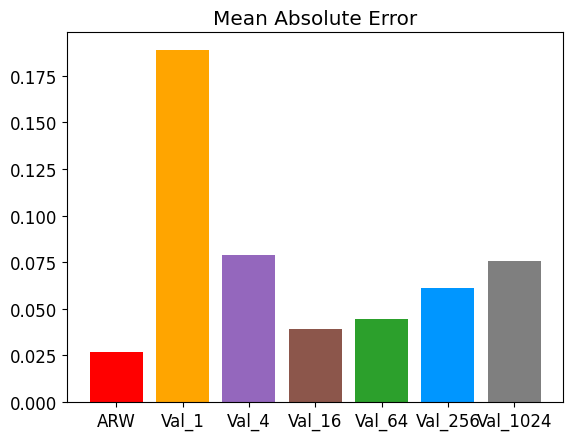

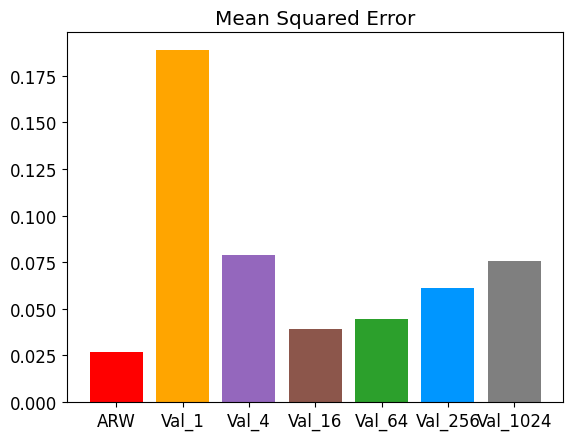

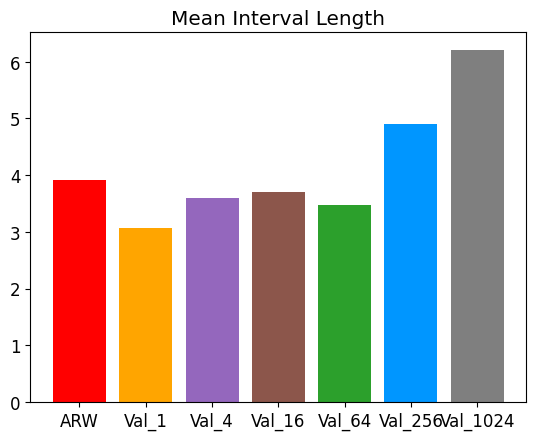

In [13]:
#process results in cdf_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
print('predicting for next period:', next_period)

cdf_array, mae_array, mae, se_ae, mse_array, mse, se_mse = summarize_cdf_dict(methods, num_trials, num_periods-1, cdf_dict, alpha)
print('mae', mae)
print('se_ae', se_ae)
print('mse', mse)
print('se_mse', se_mse)

interval_array, mean_interval, se_interval = summarize_interval_dict(methods, num_trials, num_periods-1, interval_dict)
print('mean_interval', mean_interval)
print('se_interval', se_interval)

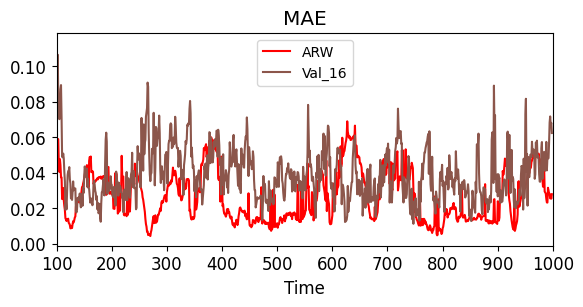

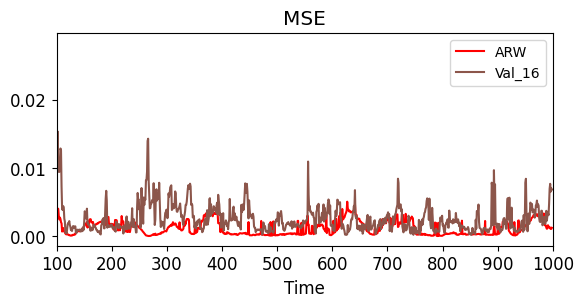

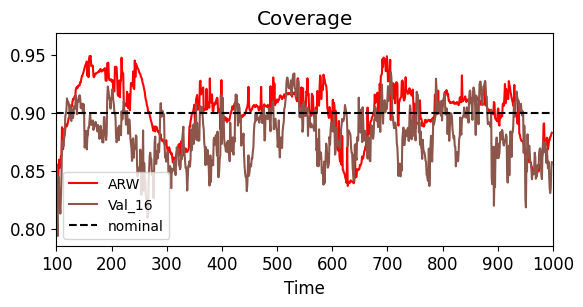

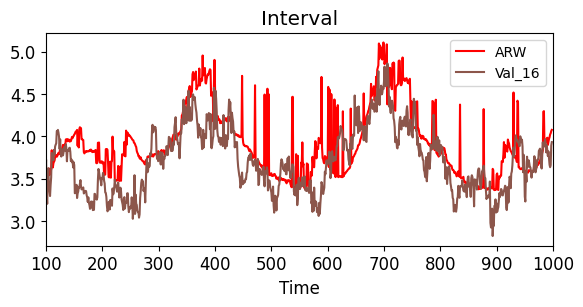

In [14]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 3]

mae_over_trials = np.mean(mae_array[:, :, :], axis=1)
mse_over_trials = np.mean(mse_array[:, :, :], axis=1)
cdf_over_trials = np.mean(cdf_array[:, :, :], axis=1)
interval_over_trials = np.mean(interval_array[:, :, :], axis=1)
plot_over_time(colors, methods, 100, 1000, mae_over_trials, methods_to_plot, title='MAE')
plot_over_time(colors, methods, 100, 1000, mse_over_trials, methods_to_plot, title='MSE')
plot_over_time(colors, methods, 100, 1000, cdf_over_trials, methods_to_plot, title='Coverage', alpha=0.1)
plot_over_time(colors, methods, 100, 1000, interval_over_trials, methods_to_plot, title='Interval')

#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')